# Kaggle Titanic Demo 4 - MajorityVote

In [12]:
import pylab as plt
%matplotlib inline
import numpy as np
import pandas as pd
import math

from featureEngineering6 import feature_engineering
from plot_learning_curve import plot_learning_curve

Kaggle_train=pd.read_csv('data/train.csv', sep=',')
Kaggle_test=pd.read_csv('data/test.csv', sep=',')

df_train, df_test = feature_engineering(Kaggle_train, Kaggle_test)

feature= ['Pclass','FamilySurvived', 'FamilyDied',
           'Title_s_Master', 'Title_s_Miss', 'Title_s_Mr', 'Title_s_Mrs',
          ]

# Acc: 0.886 +/- 0.017, F1: 0.842 +/- 0.025 # with max_depth = 4
# KS-0.81340 by max_depth=3

X, y = df_train[feature], Kaggle_train['Survived']

In [13]:
X.head()

,Pclass,FamilySurvived,FamilyDied,Title_s_Master,Title_s_Miss,Title_s_Mr,Title_s_Mrs
0,3,0,2,0,0,1,0
1,1,1,0,0,0,0,1
2,3,0,0,0,1,0,0
3,1,1,1,0,0,0,1
4,3,0,0,0,0,1,0


In [14]:
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation

from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.grid_search import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from majorityVoteClassifier import MajorityVoteClassifier


## Train, Test split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [24]:
rf = RandomForestClassifier(n_estimators=1000,
                                       criterion='entropy',
                                       random_state=1,
                                       min_samples_split=2, 
                                       min_samples_leaf=2,
                                       max_features='auto',
                                       bootstrap=True,
                                       oob_score=True,
                                       max_depth=3,
                                       #class_weight={0:0.2, 1:0.8},
                                       n_jobs=-1)

pipe_KNN = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier(n_neighbors=16))
    ])

pipe_SVC = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(C=30.0, gamma=0.05,probability=True))
    ])

tree = DecisionTreeClassifier(criterion='entropy', max_depth=4)
bagging = BaggingClassifier(
    base_estimator=tree,
    n_estimators=500,
    #max_samples=2,
    #max_features=5,
    bootstrap=True,
    bootstrap_features=False,
    random_state=1
)

extraTree = ExtraTreesClassifier(
    n_estimators=100, 
    max_depth=10,  
    min_samples_split=2, 
    random_state=0)

adaBoost = AdaBoostClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    random_state=0
)

gradientBoost = GradientBoostingClassifier(
    n_estimators=100, ## 1000 won't make difference
    learning_rate=0.1,
    max_depth=3,
    random_state=0
)



In [25]:
classifiers = [
    rf,
    pipe_KNN,
    pipe_SVC,
    bagging,
    extraTree,
    adaBoost,
    gradientBoost,
]

weights = [
    5, # RF
    5, # KNN
    5, # SVC
    5, # bagging
    5, # extraTree
    5, # adaBoost
    5, # gradientBoost
]

clf = MajorityVoteClassifier(
    classifiers=classifiers,
    weights=weights,
)

In [26]:
clf.fit(X_train, y_train)

MajorityVoteClassifier(classifiers=[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_...          presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)],
            vote='classlabel', weights=[5, 5, 5, 5, 5, 5, 5])

In [27]:
print( 'Training Acc: %.3f' % accuracy_score(clf.predict(X_train), y_train))
print( 'Training Precision: %.3f' % precision_score(clf.predict(X_train), y_train))
print( 'Training Recall: %.3f' % recall_score(clf.predict(X_train), y_train))
print( 'Training F1: %.3f' % f1_score(clf.predict(X_train), y_train))

Training Acc: 0.899
Training Precision: 0.818
Training Recall: 0.905
Training F1: 0.859


In [28]:
print( 'Test Acc: %.3f' % accuracy_score(clf.predict(X_test), y_test))
print( 'Test Precision: %.3f' % precision_score(clf.predict(X_test), y_test))
print( 'Test Recall: %.3f' % recall_score(clf.predict(X_test), y_test))
print( 'Test F1: %.3f' % f1_score(clf.predict(X_test), y_test))

Test Acc: 0.866
Test Precision: 0.753
Test Recall: 0.902
Test F1: 0.821


## Model evaluation

In [29]:
scores = cross_validation.cross_val_score(clf, X, y, scoring='accuracy', cv=8, n_jobs=-1)
print('Cross validation check for Acc: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Cross validation check for Acc: 0.888 +/- 0.017


In [30]:
scores = cross_validation.cross_val_score(clf, X, y, scoring='f1', cv=8, n_jobs=-1)
print('Cross validation check for F1: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Cross validation check for F1: 0.845 +/- 0.026


In [31]:
scores = cross_validation.cross_val_score(clf, X, y, scoring='roc_auc', cv=8, n_jobs=-1)
print('Cross validation check for ROC AUC: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Cross validation check for ROC AUC: 0.928 +/- 0.011


In [32]:
from plot_learning_curve import plot_learning_curve

<module 'matplotlib.pyplot' from '/Users/fuyangliu/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

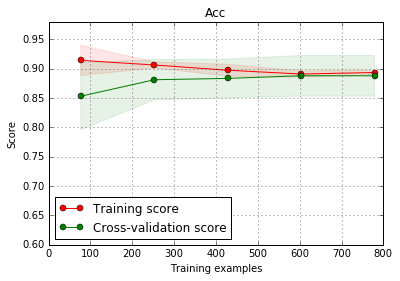

In [33]:
plot_learning_curve(clf, 'Acc', X, y, ylim=(0.6, 0.98), cv=8,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')

<module 'matplotlib.pyplot' from '/Users/fuyangliu/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

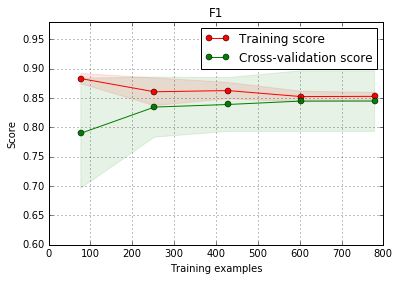

In [34]:
plot_learning_curve(clf, 'F1', X, y, ylim=(0.6, 0.98), cv=8,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='f1')

<module 'matplotlib.pyplot' from '/Users/fuyangliu/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

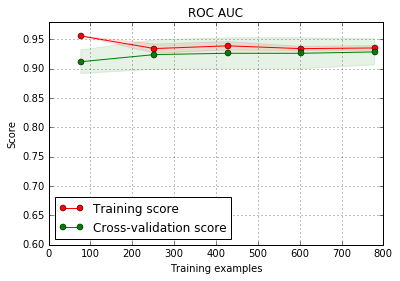

In [35]:
plot_learning_curve(clf, 'ROC AUC', X, y, ylim=(0.6, 0.98), cv=8,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='roc_auc')

## Prediction

In [36]:
clf.fit(X, y)

MajorityVoteClassifier(classifiers=[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_...          presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)],
            vote='classlabel', weights=[5, 5, 5, 5, 5, 5, 5])

In [37]:
predictions = clf.predict(df_test[feature])

In [38]:
submission = pd.DataFrame({
        "PassengerId": Kaggle_test["PassengerId"],
        "Survived": predictions
    })
submission.to_csv("Demo4-MC.1.csv", index=False)

### This gives Kaggle score: 0.76 - Not very high


## Change the weight maually:

In [49]:
feature= ['Pclass','FamilySurvived', 'FamilyDied',
           'Title_s_Master', 'Title_s_Miss', 'Title_s_Mr', 'Title_s_Mrs',
          ]

# Acc: 0.886 +/- 0.017, F1: 0.842 +/- 0.025 # with max_depth = 4
# KS-0.81340 by max_depth=3

X, y = df_train[feature], Kaggle_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [59]:
classifiers = [
    rf,
    pipe_KNN,
    pipe_SVC,
    #bagging,
    #extraTree,
    #adaBoost,
    #gradientBoost,
]

weights = [
    6, # RF
    5, # KNN
    4, # SVC
    #3, # bagging
    #0.01, # extraTree
    #0.01, # adaBoost
    #0.01, # gradientBoost
]

clf = MajorityVoteClassifier(
    classifiers=classifiers,
    weights=weights,
)

In [60]:
clf.fit(X_train, y_train)

MajorityVoteClassifier(classifiers=[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_...
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])],
            vote='classlabel', weights=[6, 5, 4])

Training Acc: 0.888
Training Precision: 0.803
Training Recall: 0.889
Training F1: 0.844
Test Acc: 0.844
Test Precision: 0.726
Test Recall: 0.869
Test F1: 0.791
Cross validation check for Acc: 0.878 +/- 0.019
Cross validation check for F1: 0.830 +/- 0.030
Cross validation check for ROC AUC: 0.915 +/- 0.013


<module 'matplotlib.pyplot' from '/Users/fuyangliu/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

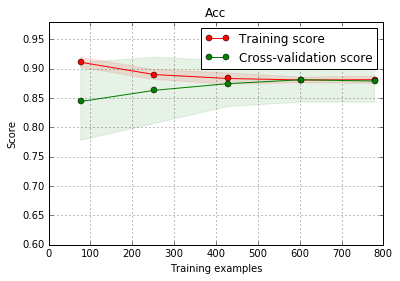

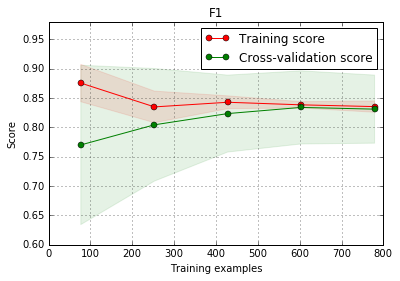

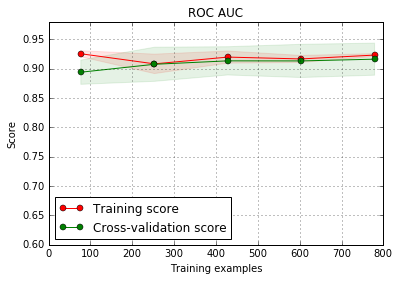

In [61]:
print( 'Training Acc: %.3f' % accuracy_score(clf.predict(X_train), y_train))
print( 'Training Precision: %.3f' % precision_score(clf.predict(X_train), y_train))
print( 'Training Recall: %.3f' % recall_score(clf.predict(X_train), y_train))
print( 'Training F1: %.3f' % f1_score(clf.predict(X_train), y_train))

print( 'Test Acc: %.3f' % accuracy_score(clf.predict(X_test), y_test))
print( 'Test Precision: %.3f' % precision_score(clf.predict(X_test), y_test))
print( 'Test Recall: %.3f' % recall_score(clf.predict(X_test), y_test))
print( 'Test F1: %.3f' % f1_score(clf.predict(X_test), y_test))

scores = cross_validation.cross_val_score(clf, X, y, scoring='accuracy', cv=8, n_jobs=-1)
print('Cross validation check for Acc: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

scores = cross_validation.cross_val_score(clf, X, y, scoring='f1', cv=8, n_jobs=-1)
print('Cross validation check for F1: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

scores = cross_validation.cross_val_score(clf, X, y, scoring='roc_auc', cv=8, n_jobs=-1)
print('Cross validation check for ROC AUC: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

plot_learning_curve(clf, 'Acc', X, y, ylim=(0.6, 0.98), cv=8,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')

plot_learning_curve(clf, 'F1', X, y, ylim=(0.6, 0.98), cv=8,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='f1')

plot_learning_curve(clf, 'ROC AUC', X, y, ylim=(0.6, 0.98), cv=8,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='roc_auc')